In [1]:
import numpy as np
import xarray as xr
import datacube 

import dask
from dask.distributed import Client

import sys
sys.path.append('src')
import DEADataHandling
# import lazily_load_clearlandsat as llcLS
import query_from_shp

### Info for parallel processing with Dask
1. If reading netcdf files make sure each worker has one thread
2. memory_limit is per worker not per cluster of workers
3. When launching multiple workers (needed when reading netcdfs) on the same node you have to supply memory limit, otherwise every worker will assume they have all the memory

In [ ]:
client = Client(n_workers=4, threads_per_worker=1, memory_limit='5GB')
client

### User Inputs

In [ ]:
#If not using a polygon then enter your AOI coords
#below:
lat, lon = -34.294, 146.037
latLon_adjust = 0.125

start = '1987-12-01'
end = '2019-05-31'

shp_fpath = "/g/data/r78/cb3058/dea-notebooks/dcStats/data/spatial/griffith_MSAVI_test.shp"
chunk_size = 250

### Load data

In [ ]:
# query = query_from_shp.query_from_shp(shp_fpath, start, end)
query = {'lon': (lon - latLon_adjust, lon + latLon_adjust),
         'lat': (lat - latLon_adjust, lat + latLon_adjust),
        'time': (start, end)}

# query = query_from_shp.query_from_shp(shp_fpath, start, end)
dc = datacube.Datacube(app='load_clearlandsat')
ds = DEADataHandling.load_clearlandsat(dc=dc, query=query, sensors=['ls5','ls7','ls8'], bands_of_interest=['nir', 'red'], lazy_load=True,
                                      dask_chunks = {'x': chunk_size, 'y': chunk_size}, masked_prop=0.25, mask_pixel_quality=True)
ds

In [ ]:
len(ds.chunks['y']) * len(ds.chunks['x']) 

In [ ]:
def msavi_func(nir, red):
    return (2*nir+1-np.sqrt((2*nir+1)**2 - 8*(nir-red)))/2

def msavi_ufunc(ds):
    return xr.apply_ufunc(
        msavi_func, ds.nir, ds.red,
        dask='parallelized',
        output_dtypes=[float])

def compute_seasonal(data):		
    msavi = msavi_ufunc(data)
    #calculate the MSAVI    
    msavi = msavi.resample(time='M').mean('time')
    #calculate seasonal climatology
    msavi_seasonalClimatology = msavi.groupby('time.season').mean('time')
    #resample monthly msavi to seasonal means
    msavi_seasonalMeans = msavi.resample(time='QS-DEC').mean('time')
    #calculate anomalies
    masvi_anomalies = msavi_seasonalMeans.groupby('time.season') - msavi_seasonalClimatology
    return masvi_anomalies

a = compute_seasonal(ds)
a.to_netcdf('results/test.nc')  

In [3]:
#reopen without dask chunks and it'll plot quickly
b = xr.open_dataarray('results/griffith_MSAVI_anomalies.nc').isel(time=range(-6,-2))
b

<xarray.DataArray (time: 4, y: 4834, x: 4134)>
[79935024 values with dtype=float64]
Coordinates:
  * y        (y) float64 -3.754e+06 -3.754e+06 ... -3.875e+06 -3.875e+06
  * x        (x) float64 1.232e+06 1.232e+06 1.232e+06 ... 1.336e+06 1.336e+06
  * time     (time) datetime64[ns] 2017-12-01 2018-03-01 2018-06-01 2018-09-01
    season   (time) object ...

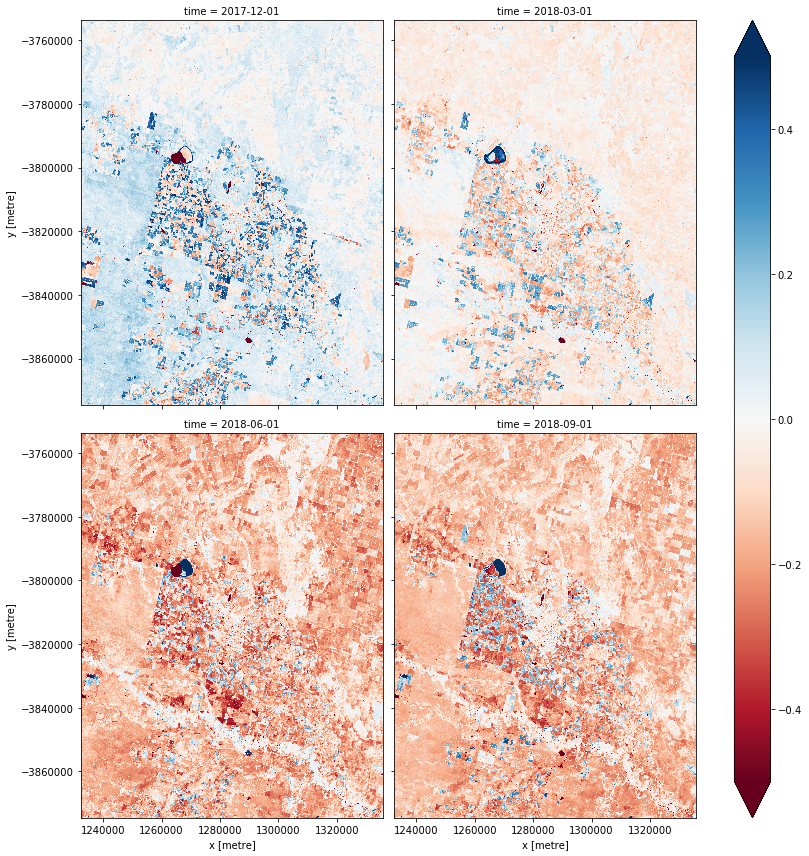

In [5]:
b.plot(x='x',y='y', col='time', col_wrap=2, vmin=-0.5,vmax=0.5, cmap='RdBu', figsize=(12,12))

In [ ]:
b.mean(['x', 'y']).plot(figsize=(12,5), ylim=(-0.25, 0.25))

### Compute monthly MSAVI anomalies

In [ ]:
def compute_monthly(data):		
    #calculate the MSAVI
    msavi = xr.DataArray(data = (2*data.nir+1-np.sqrt((2*data.nir+1)**2 - 8*(data.nir-data.red)))/2,
                  coords=data.coords,attrs=dict(crs=data.crs))
    
    msavi = msavi.resample(time='M').mean('time')
    
    #calculate climatology
    climatology = msavi.groupby('time.month').mean('time')
    #calculate anomalies
    anomalies = msavi.groupby('time.month') - climatology

    return anomalies, climatology 

x, y = compute_monthly(ds)

In [ ]:
y.plot(x='x', y='y', col='month',col_wrap=4, vmin=0.0,vmax=1.0, figsize=(15,10), cmap='plasma')

In [ ]:
x.mean(['x', 'y']).plot(figsize=(12,5), ylim=(-0.25, 0.25))

In [ ]:
# 2018 anomalies
# x.isel(time=range(-17,-5)).plot(x='x',y='y',col='time',col_wrap=4,figsize=(13,10), vmin=-0.5, vmax=0.5, cmap='BrBG')

In [ ]:
# 2010 anomalies
# x.isel(time=range(265,277)).plot(x='x',y='y',col='time',col_wrap=4,figsize=(13,10), vmin=-0.5, vmax=0.5, cmap='BrBG')


### Seasonal MSAVi anomalies 

Not sure this is working as expected. Appears that the mean of the anomalies is not zero as you'd expect.

In [ ]:
 def compute_seasonal(data):		
    #calculate the MSAVI
    msavi = xr.DataArray(data = (2*data.nir+1-np.sqrt((2*data.nir+1)**2 - 8*(data.nir-data.red)))/2,
              coords=data.coords,attrs=dict(crs=data.crs))
    
    msavi = msavi.resample(time='M').mean('time')
    #calculate seasonal climatology
    msavi_seasonalClimatology = msavi.groupby('time.season').mean('time')
    
    #resample monthly msavi to seasonal means
    msavi_seasonalMeans = msavi.resample(time='QS-DEC').mean('time')
    #calculate anomalies
    masvi_anomalies = msavi_seasonalMeans.groupby('time.season') - msavi_seasonalClimatology

    return masvi_anomalies, msavi_seasonalClimatology

a,b=compute_seasonal(ds)

In [ ]:
b.plot(x='x',y='y', col='season',col_wrap=2, vmin=0,vmax=1.0, figsize=(10,7), cmap='plasma')

In [ ]:
a.mean(['x', 'y']).plot(figsize=(12,5), ylim=(-0.25, 0.25))

In [ ]:
# 2018 anomalies
# a.isel(time=range(-6,-2)).plot(x='x',y='y',col='time',col_wrap=2,figsize=(13,10), vmin=-0.5, vmax=0.5, cmap='BrBG')

In [ ]:
# 2010 anomalies
# a.isel(time=range(-38,-34)).plot(x='x',y='y',col='time',col_wrap=2,figsize=(13,10), vmin=-0.5, vmax=0.5, cmap='BrBG')

### CUTS

In [ ]:
def msavi_func(nir, red):
    return (2*nir+1-np.sqrt((2*nir+1)**2 - 8*(nir-red)))/2

def msavi_ufunc(ds):
    return xr.apply_ufunc(
        msavi_func, ds.nir, ds.red,
        dask='parallelized',
        output_dtypes=[float])

msavi = msavi_ufunc(ds_mo).compute()

In [ ]:
climatology = msavi.groupby('time.month').mean('time')

anomalies = msavi.groupby('time.month') - climatology

In [ ]:
    #Functions for weighting months to help with seasonal climatology
    dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
           '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
           'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
           'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
           'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
           'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
           '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
           '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]}

    def leap_year(year, calendar='standard'):
        """Determine if year is a leap year"""
        leap = False
        if ((calendar in ['standard', 'gregorian',
            'proleptic_gregorian', 'julian']) and
            (year % 4 == 0)):
            leap = True
            if ((calendar == 'proleptic_gregorian') and
                (year % 100 == 0) and
                (year % 400 != 0)):
                leap = False
            elif ((calendar in ['standard', 'gregorian']) and
                     (year % 100 == 0) and (year % 400 != 0) and
                     (year < 1583)):
                leap = False
        return leap

    def get_dpm(time, calendar='standard'):
        """
        return a array of days per month corresponding to the months provided in `months`
        """
        month_length = np.zeros(len(time), dtype=np.int)

        cal_days = dpm[calendar]

        for i, (month, year) in enumerate(zip(time.month, time.year)):
            month_length[i] = cal_days[month]
            if leap_year(year, calendar=calendar):
                month_length[i] += 1
        return month_length

    def season_mean(ds, calendar='standard'):
        # Make a DataArray of season/year groups
        year_season = xr.DataArray(ds.time.to_index().to_period(freq='Q-NOV').to_timestamp(how='E'),
                                   coords=[ds.time], name='year_season')

        # Make a DataArray with the number of days in each month, size = len(time)
        month_length = xr.DataArray(get_dpm(ds.time.to_index(), calendar=calendar),
                                    coords=[ds.time], name='month_length')
        # Calculate the weights by grouping by 'time.season'
        weights = month_length.groupby('time.season') / month_length.groupby('time.season').sum()

        # Test that the sum of the weights for each season is 1.0
        np.testing.assert_allclose(weights.groupby('time.season').sum().values, np.ones(4))

        # Calculate the weighted average
        return (ds * weights).groupby('time.season').sum(dim='time')

    #calculate the seasonal climatology
#     msavi_seasonalClimatology = season_mean(msavi)

In [ ]:
def load_chunked_nbarx(dc, sensor, query, product='nbart', bands_of_interest='', filter_pq=True, dask_chunks={}, like=None):
    
    product_name = '{}_{}_albers'.format(sensor, product)
    mask_product = '{}_{}_albers'.format(sensor, 'pq')
    
    if like is None:
        
        # If bands of interest are given, assign measurements in dc.load call
        if bands_of_interest:
            ds = dc.load(product=product_name, measurements=bands_of_interest,
                         group_by='solar_day', **query, dask_chunks=dask_chunks)
        # If no bands of interest given, run without specifying measurements
        else:
            ds = dc.load(product=product_name, group_by='solar_day', **query, dask_chunks=dask_chunks)

        # Proceed if the resulting call returns data
        if ds.variables:
            # If pixel quality filtering is enabled, extract PQ data to use as mask
            if filter_pq:
                sensor_pq = dc.load(product=mask_product, fuse_func=ga_pq_fuser,
                                    group_by='solar_day', **query, dask_chunks=dask_chunks)

                # If PQ call returns data, use to mask input data
                if sensor_pq.variables:
                    good_quality = masking.make_mask(sensor_pq.pixelquality,
                                                     cloud_acca='no_cloud',
                                                     cloud_shadow_acca='no_cloud_shadow',
                                                     cloud_shadow_fmask='no_cloud_shadow',
                                                     cloud_fmask='no_cloud',
                                                     blue_saturated=False,
                                                     green_saturated=False,
                                                     red_saturated=False,
                                                     nir_saturated=False,
                                                     swir1_saturated=False,
                                                     swir2_saturated=False,
                                                     contiguous=True)

                    # Apply mask to preserve only good data
                    ds = ds.where(good_quality)
            # Replace nodata values with nans
                ds = masking.mask_invalid_data(ds)
            return ds
        else:
            return None, None, None
    
    else:
        #If bands of interest are given, assign measurements in dc.load call
        if bands_of_interest:
            ds = dc.load(product=product_name, measurements=bands_of_interest,
                         group_by='solar_day',dask_chunks=dask_chunks, like=like)

        # If no bands of interest given, run without specifying measurements
        else:
            ds = dc.load(product=product_name, group_by='solar_day', dask_chunks=dask_chunks, like=like)

        # Proceed if the resulting call returns data
        if ds.variables:
            # If pixel quality filtering is enabled, extract PQ data to use as mask
            if filter_pq:
                sensor_pq = dc.load(product=mask_product, fuse_func=ga_pq_fuser,
                                    group_by='solar_day', dask_chunks=dask_chunks, like=like)

                # If PQ call returns data, use to mask input data
                if sensor_pq.variables:
                    good_quality = masking.make_mask(sensor_pq.pixelquality,
                                                     cloud_acca='no_cloud',
                                                     cloud_shadow_acca='no_cloud_shadow',
                                                     cloud_shadow_fmask='no_cloud_shadow',
                                                     cloud_fmask='no_cloud',
                                                     blue_saturated=False,
                                                     green_saturated=False,
                                                     red_saturated=False,
                                                     nir_saturated=False,
                                                     swir1_saturated=False,
                                                     swir2_saturated=False,
                                                     contiguous=True)

                    # Apply mask to preserve only good data
                    ds = ds.where(good_quality)
            # Replace nodata values with nans
                ds = masking.mask_invalid_data(ds)
            return ds
        else:
            return None, None, None

def load_aligned_nbarx(dc, query, sensors, product='nbart', bands_of_interest='', filter_pq=True, dask_chunks={}):
    print('loading ' + sensors[0])
    
    #list for adding loaded data too
    filtered_sensors = []
    
    #load the first sensor data and append to list
    ds1 = load_chunked_nbarx(dc, query, sensor=sensors[0], product=product, bands_of_interest=bands_of_interest,
                             filter_pq=filter_pq, dask_chunks=dask_chunks, like=None)
    
    filtered_sensors.append(ds1)
    
    #now load the other sensors using the first sensor as the 'like' parameter and append
    for sensor in sensors[1:]:
        print("\r", 'loading sensor ' + sensor, end='')
        ds = load_chunked_nbarx(dc,sensor=sensors[0], product=product, bands_of_interest=bands_of_interest,
                                filter_pq=filter_pq, dask_chunks=dask_chunks, like=ds1)
        filtered_sensors.append(ds1)
    
    # Concatenate all sensors into one big xarray dataset, and then sort by time 
    print(', concatenating & sorting sensors')
    combined_ds = xr.concat(filtered_sensors, dim='time')
    combined_ds = combined_ds.sortby('time')                                                               
    # Return combined dataset
    return combined_ds

In [ ]:
query = {'lon': (lon - latLon_adjust, lon + latLon_adjust),
         'lat': (lat - latLon_adjust, lat + latLon_adjust),
        'time': (start, end)}

# query = query_from_shp.query_from_shp(shp_fpath, start, end)
dc = datacube.Datacube(app='load_clearlandsat')
ds = load_aligned_nbarx(dc=dc, sensors=['ls7', 'ls8'], query=query, bands_of_interest=['nir', 'red'], 
                        filter_pq=True, dask_chunks = {'x': chunk_size, 'y': chunk_size})
ds